### Use iterThreshA() algo & visually debug with colorcube plots

##### Specifically, we want to see:
 - what type of boundaries get made by the algo
 - why does it perform worse than apriori thresh?
   - becasue green isn't maxed out?
 - how to add multiple OR threshes using boosting

In [195]:
import os, sys, copy, random, pickle
sys.path.append("../")
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from modules.Interproc import DBInterface
from modules.Interproc import GuiviewState
from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.ImgUtils import (filter_pixels_circle, crop_img)

from modules.AnalysisHelpers import ( multiPlot, colorCube,
         SubprocColorCube, subprocColorCube, buildConfusionData, 
         buildConfusionPlotData, buildRegionMarkers, confusionPlotByViews,
         confusionPlotByImage, PixelConfusionMatrix, cvtPlot,
         applyTracker, EvalTracker, presetCubeViews, bytesToPic,
         croppedPic, bytesToPic2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load and Inspect Data

In [2]:
#Load GS data into workbook

    # these gs-states are from data/proc/tmp/dec14/output5/6.procP
    
    # subscripts: g for Green; o for Orange

    # note: these are output from an already scored video, thus the GS's 
    #       have displayInputScore and not a displayOutputScore

DATA_DIR = "../data/misc/books/iterthresha-vizdebug-1/"

db_name = "interprocGreen.db"
gsDb = DBInterface(os.path.join(DATA_DIR, db_name))
listGSg = [ pickle.loads(d[1]) for d in gsDb.selectAll()]

db_name = "interprocOrange.db"
gsDb = DBInterface(os.path.join(DATA_DIR, db_name))
listGSo = [ pickle.loads(d[1]) for d in gsDb.selectAll()]

print [_gs.frameCounter for _gs in listGSg]
print [_gs.frameCounter for _gs in listGSo]

[0, 22, 40, 47, 49, 78, 84, 125, 188, 380]
[0, 9, 78, 116, 136, 176, 195, 246, 307, 340]


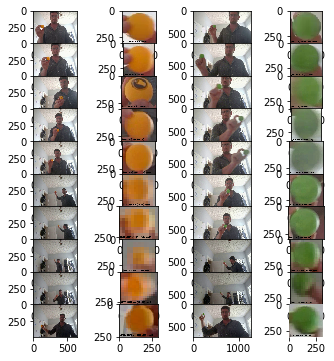

In [3]:
#View our Data
col1, col2, col3, col4 = [], [], [], []

for _gs in listGSo:
    _gs.initDisplay()
    col1.append(_gs.getOrigFrame())
    col2.append(_gs.display.scoreFrame.copy())
    
for _gs in listGSg:
    _gs.initDisplay()
    col3.append(_gs.getOrigFrame())
    col4.append(_gs.display.scoreFrame.copy())
    
#     data2.append(_gs.getZoomWindow())
chart_data = [col1, col2, col3, col4]

#concise view
multiPlot(chart_data, hspace = 0, wspace = 0, figsize = (6,6))

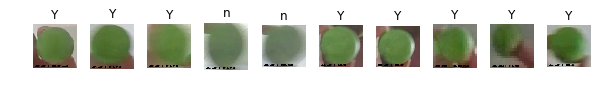

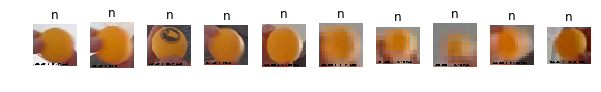

In [4]:
#View which frames of each video have successful Tracks

    #note: orange does not have a known region yet so all tracks will fail

ev = EvalTracker()
chart_legend = ["n", "Y"]

def showSuccess(_ballColor, _listGS, _listImgs):
    ''' display a plot of each scoreWindow and Y or n for trackSuccess'''

    tracker = TrackFactory(on=True)
    tracker.setInit(ballColor=_ballColor)
    tracker.setAlgoEnum(1)

    outputData = applyTracker(listGSg, tracker, bLogPlts=False)

    chart_col_title = [ chart_legend[int(ev.checkTrackSuccess(elem))] 
                          for elem in outputData['listScore']
                      ]
    chart_data = [[elem] for elem in _listImgs]

    multiPlot(chart_data
             ,input_frame_titles = chart_col_title
             ,bGrid = False
             ,bForceTitles = True
             )

showSuccess("green", copy.deepcopy(listGSg), copy.deepcopy(col4))
showSuccess("orange", copy.deepcopy(listGSo), copy.deepcopy(col2))

### Plot ColorCubes on Multiple Good Tracks vs Bad Ones

In [5]:
pcm = PixelConfusionMatrix()

In [6]:
tracker = TrackFactory(on=True)
tracker.setInit(ballColor="green")
tracker.setAlgoEnum(1)
thresh1 = (tracker.getTrackParams()['thresh_lo']
           ,tracker.getTrackParams()['thresh_hi'])
thresh1

((29, 86, 6), (64, 255, 255))

In [7]:
views1 = presetCubeViews()
view1 = views1[0][1]
view1

{'azimuth': -81, 'elevation': 95}

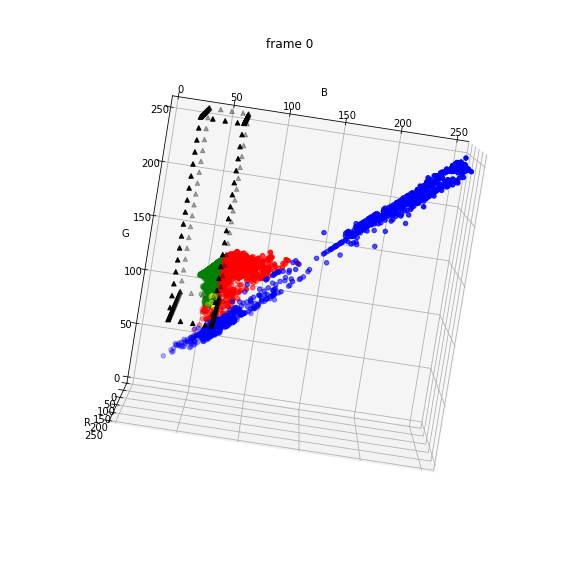

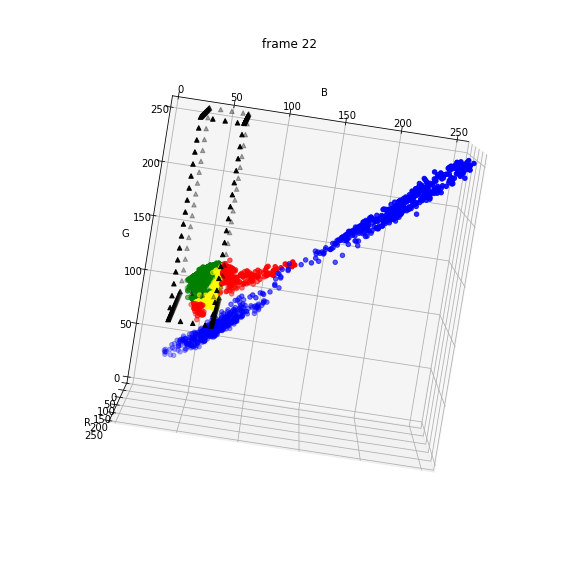

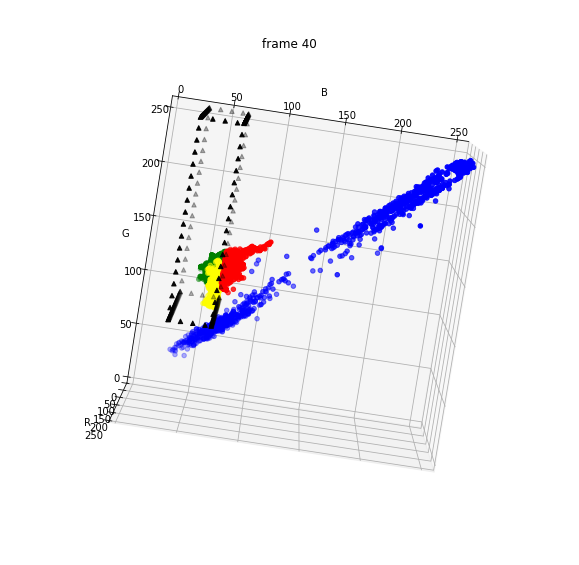

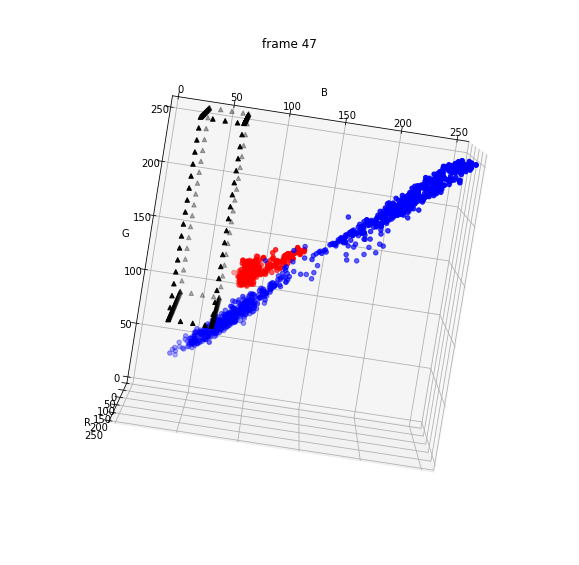

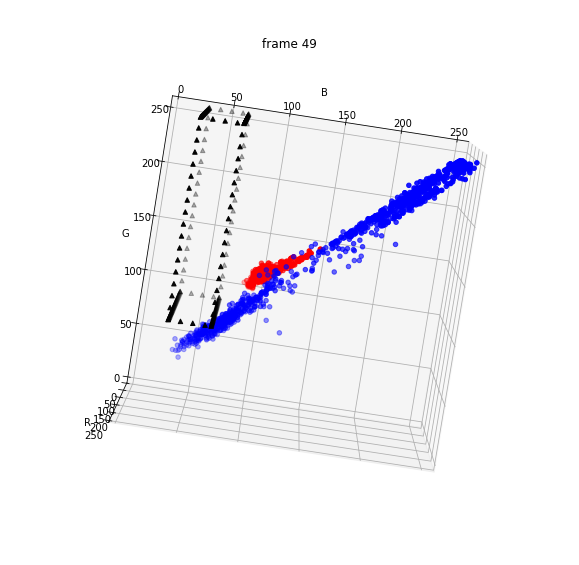

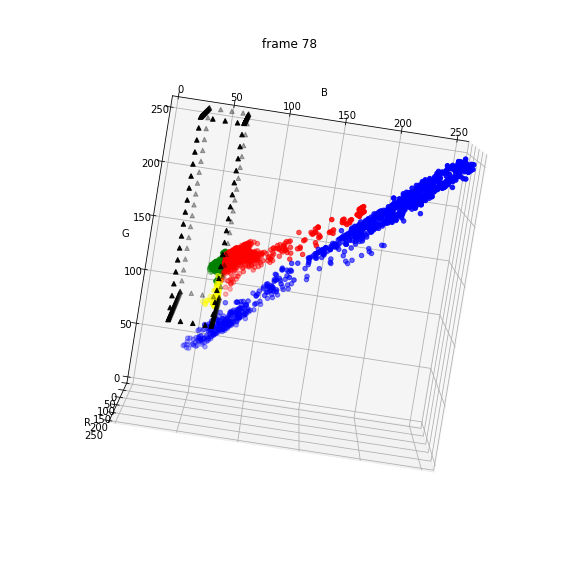

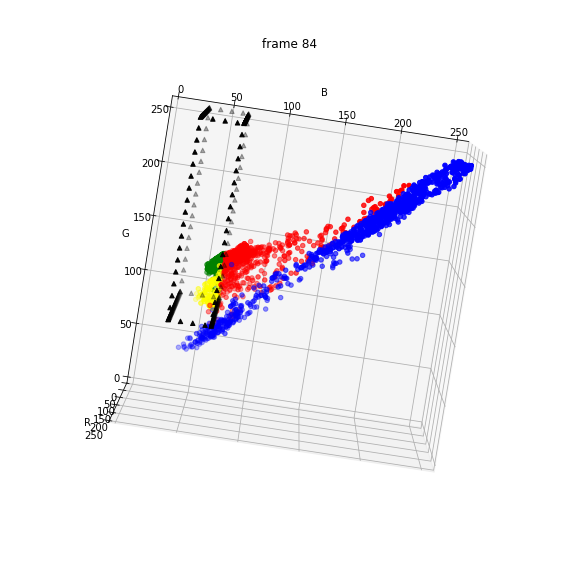

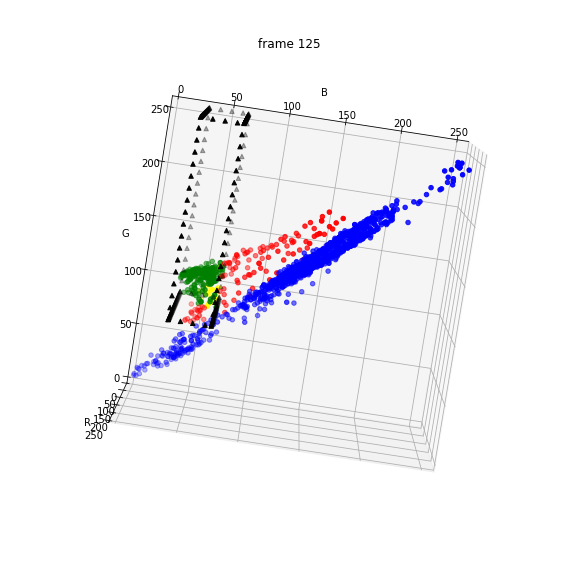

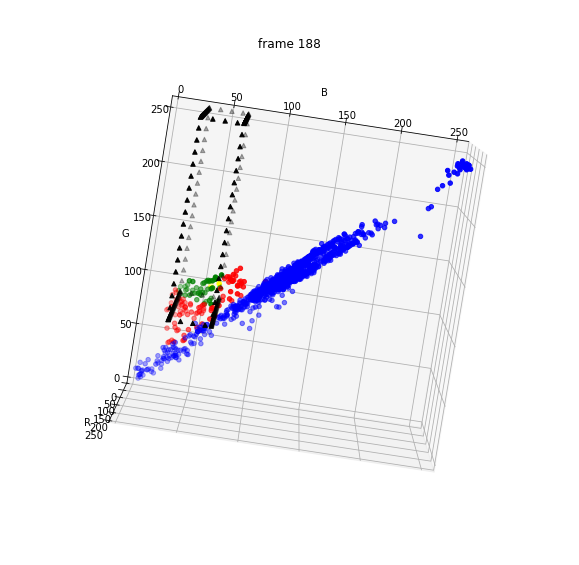

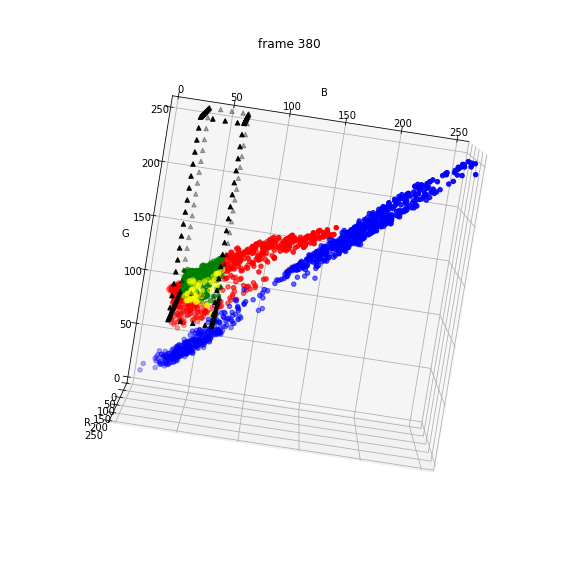

In [8]:
# green tracks

confusionPlotByImage( listGS = listGSg
                     ,inputThresh = thresh1
                     ,viewPositionDefined = view1
                     ,bOutputScore = False
                    )

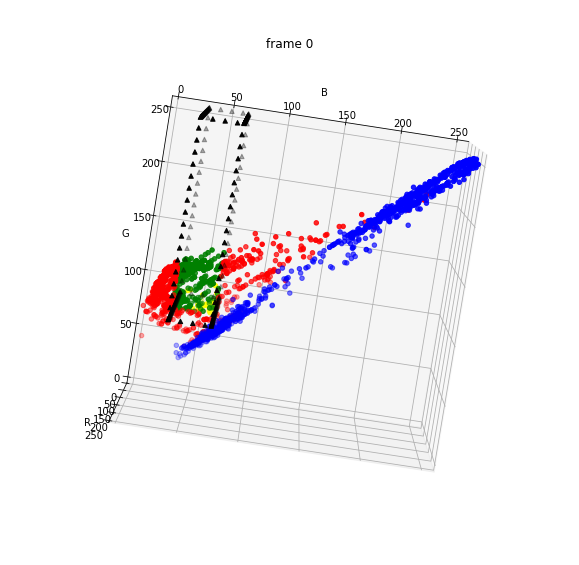

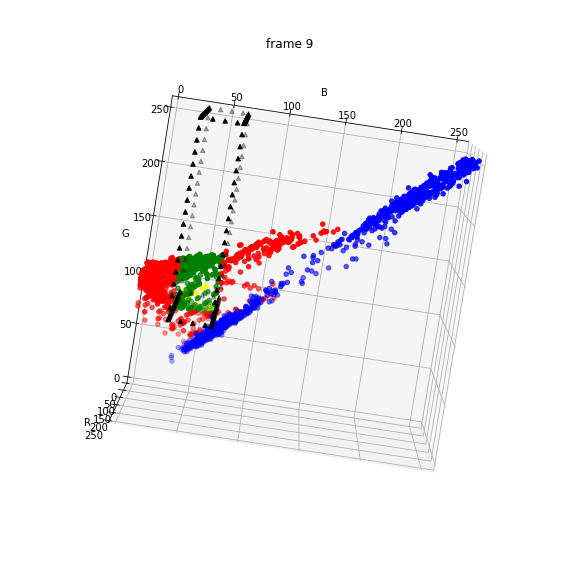

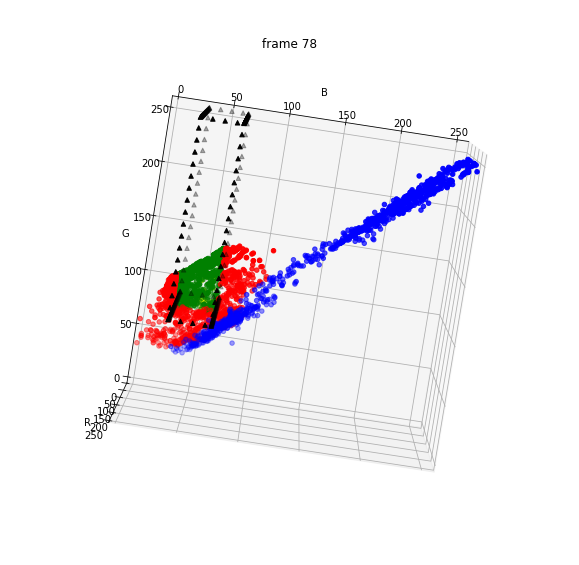

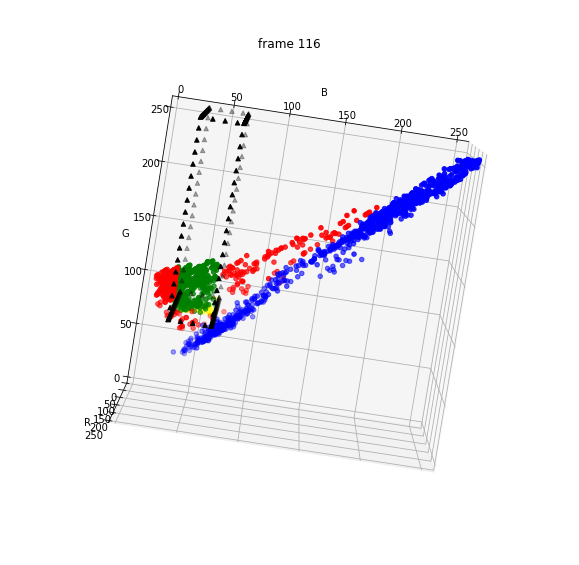

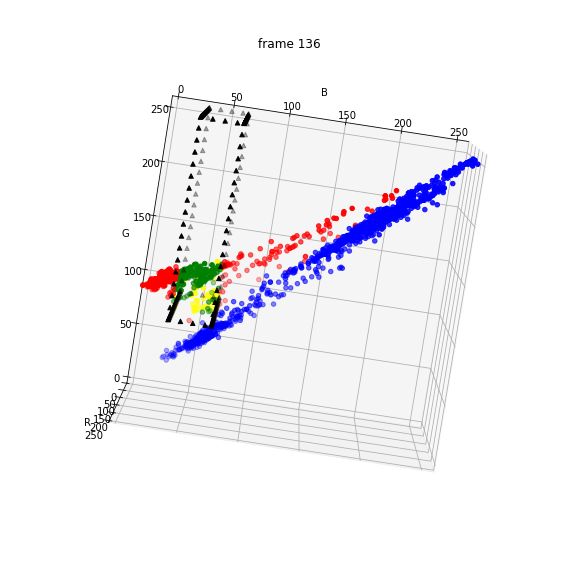

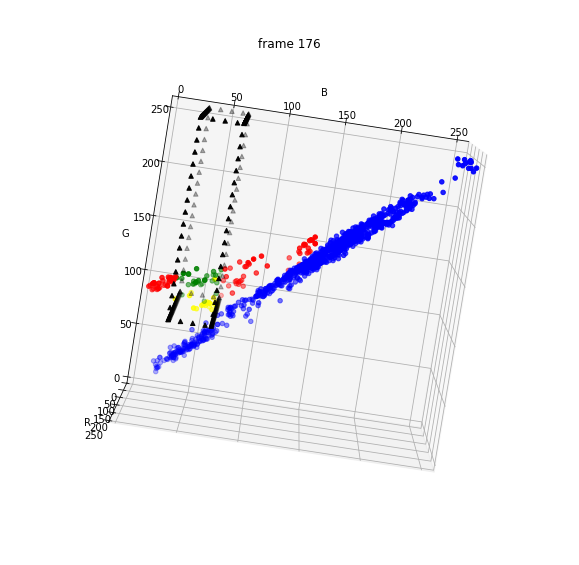

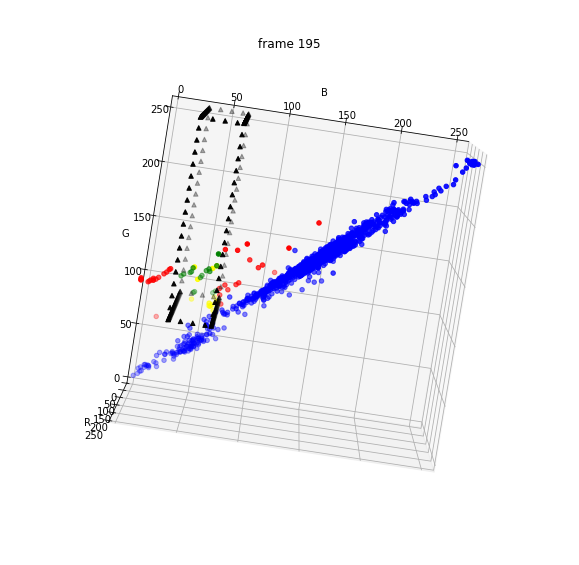

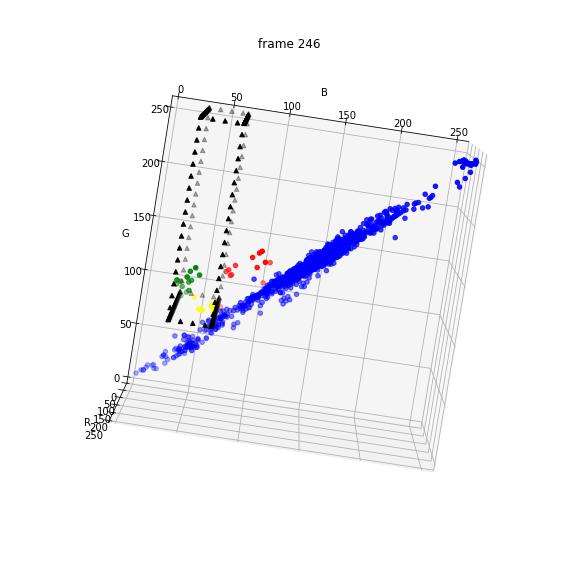

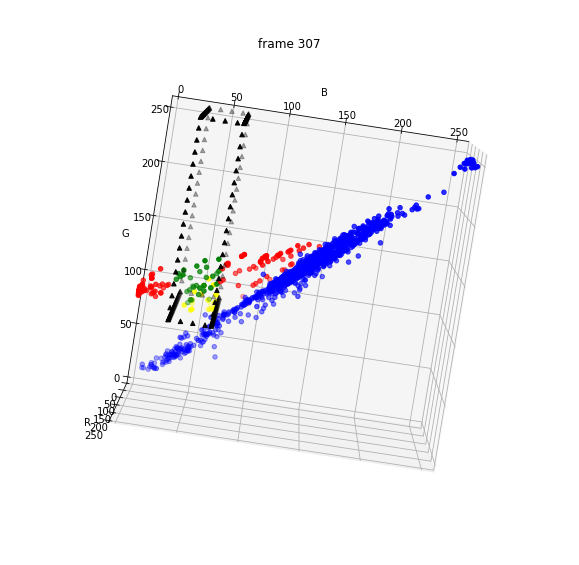

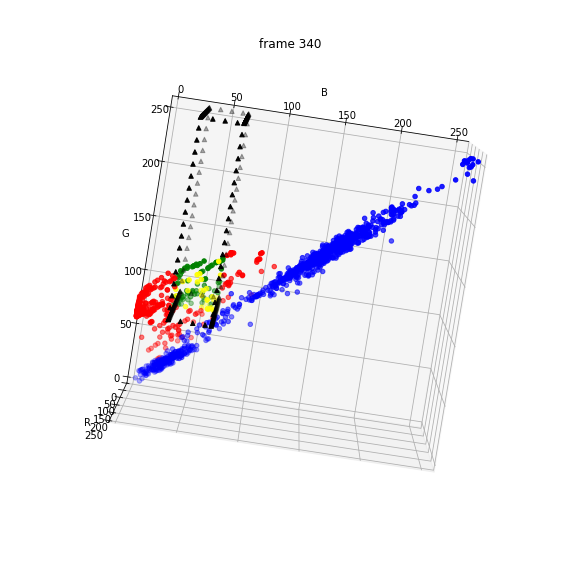

In [9]:
#orange tracks (with green thresh, still somewhat works)

confusionPlotByImage( listGS = listGSo
                     ,inputThresh = thresh1
                     ,viewPositionDefined = view1
                     ,bOutputScore = False
                    )

#### View the mis-tracked frames in detail

In [21]:
[_gs.frameCounter for _gs in listGSg]

[0, 22, 40, 47, 49, 78, 84, 125, 188, 380]

In [22]:
#frame47 - no-track
bad_gs = listGSg[3]

In [26]:
confuData = buildConfusionData(bad_gs, [thresh1], bOutputScore = False)

In [28]:
confuData

<modules.AnalysisHelpers.PixelConfusionMatrix instance at 0x1EED5120>

In [29]:
confuData.displayVals()

                                         True          False
                        921600           6625         914975
       Positive              0              0              0
       Negative         921600         914975           6625


In [45]:
#sample lots of points for TN, to see outlier boundaries
plotData = buildConfusionPlotData(confuData, N = 10**4)

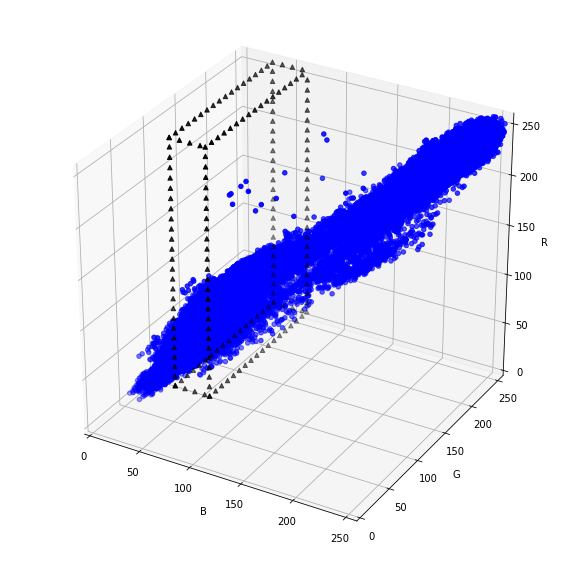

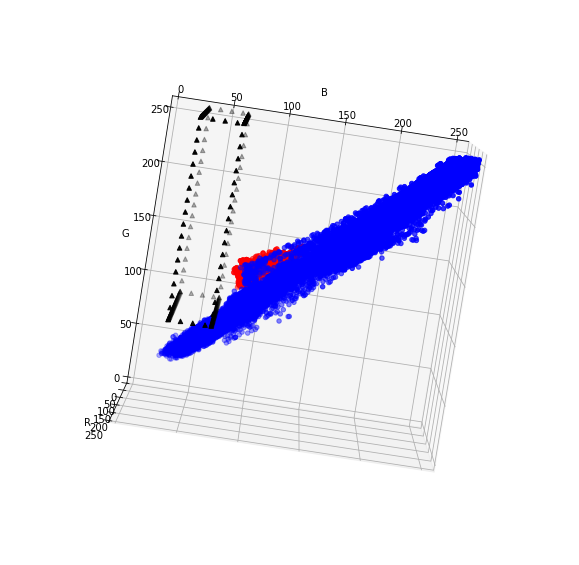

In [37]:
_regionMarkers = buildRegionMarkers([thresh1])

colorCube(confData = plotData, regionMarkers = _regionMarkers)

colorCube( confData = plotData
          ,regionMarkers = _regionMarkers
#           ,title = 
          ,viewPositionDefined = view1
          ,bInitPosition = True
          ,figsize = (10,10)
         )

In [41]:
subprocColorCube( confData = plotData, regionMarkers = _regionMarkers)

loaded class type:  SubprocColorCube


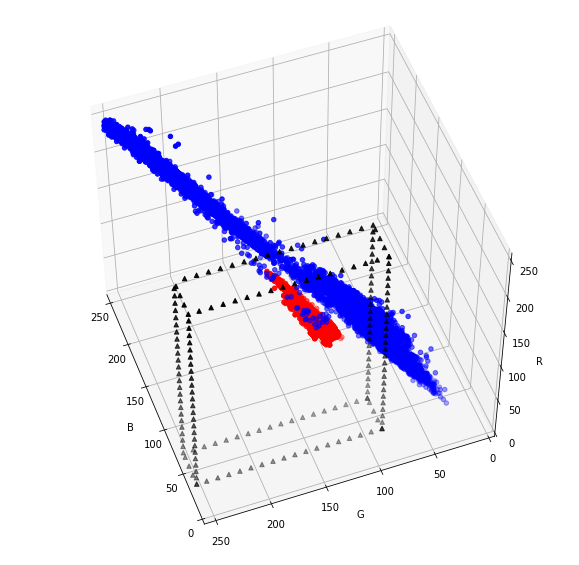

In [43]:
#clear segmentation for frame 47
p = SubprocColorCube()
p.load()
p.callPlot()

loaded class type:  SubprocColorCube


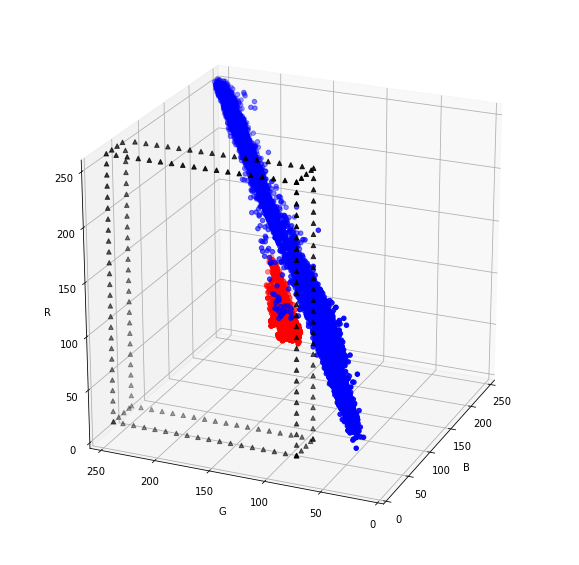

In [44]:
p2 = SubprocColorCube()
p2.load()
p2.callPlot()

### Plot ColorCube Data of just the Ball

In [10]:
from modules.IterThresh import iterThreshA
from modules.AnalysisHelpers import imgToColors, pointsToList

In [11]:
_gs = listGSg[0]

In [12]:
pcm = PixelConfusionMatrix(img = _gs.getOrigFrame()
                          ,threshes = [thresh1]
                          ,circle = _gs.displayInputScore['0']['data']
                          )
pcm.calc()

In [13]:
#TODO - add "truePix" to PCM, from the circleMask
pix1 = pcm.tpPix.copy()
pix2 = pcm.fnPix.copy()
pix = np.concatenate((pix1,pix2))

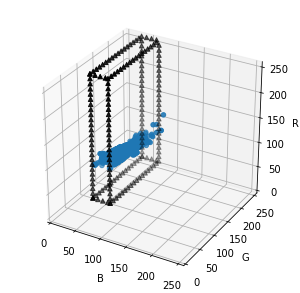

In [14]:
colorCube( *pointsToList(pix)
          ,regionMarkers = buildRegionMarkers([thresh1]) 
          ,figsize = (5,5)
         )
subprocColorCube( *pointsToList(pix)
          ,regionMarkers = buildRegionMarkers([thresh1]) 
         )

### Introducing iterTheshA

In [15]:
# arrange to 3-dim
pix2 = np.array(pix, dtype='uint8', ndmin = 3)
pix2.shape

#run iterThresh
outputLog = iterThreshA( pix2
                         ,goal_pct = .95
                         ,steep = False)

#parse output
thresh_out = (outputLog[1][3], outputLog[1][4])
thresh_out

([46, 83, 80], [99, 136, 120])

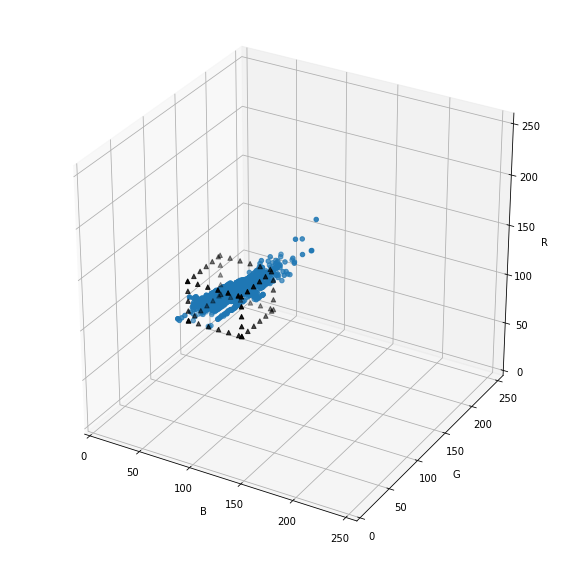

In [16]:
colorCube( *pointsToList(pix)
          ,regionMarkers = buildRegionMarkers([thresh_out]) 
         )
subprocColorCube( *pointsToList(pix)
          ,regionMarkers = buildRegionMarkers([thresh_out]) 
         )

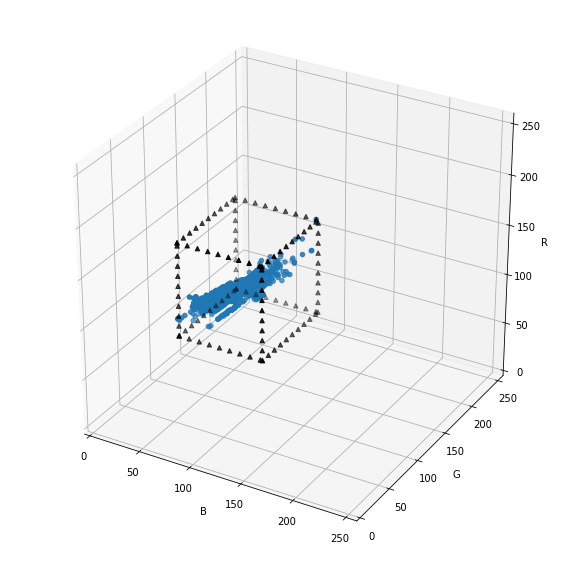

In [46]:
#SAME - but with steep=True

pix2 = np.array(pix, dtype='uint8', ndmin = 3)

outputLog = iterThreshA( pix2
                         ,goal_pct = .95
                         ,steep = True)

thresh_out = (outputLog[1][3], outputLog[1][4])

colorCube( *pointsToList(pix)
          ,regionMarkers = buildRegionMarkers([thresh_out]) 
         )
subprocColorCube( *pointsToList(pix)
          ,regionMarkers = buildRegionMarkers([thresh_out]) 
         )


As we can see, the issue is that we constrict the region too much; we should extend max-green and max-red

In [ ]:
# TODO
#  - show stagewise progression of iterThresh
#  - show non ball data in the cube, dif colors
#  - show multiple frames having done iterThresh on same cube

In [47]:
# it's pretty clear that any 1 cube approach will not work here 
# as everything is in comparison to a distance from the orgin line

### Introducing SKLearn

In [19]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [55]:
plt.figure(figsize=(12,12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

<Figure size 864x864 with 0 Axes>

In [56]:
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

In [67]:
print np.unique(y_pred)
print len(y_pred)
print np.unique(y)
print X.shape
X[:3]

[0 1]
1500
[0 1 2]
(1500, 2)


array([[ -5.19811282,   0.64186932],
       [ -5.75229538,   0.41862711],
       [-10.84489837,  -7.55352273]])

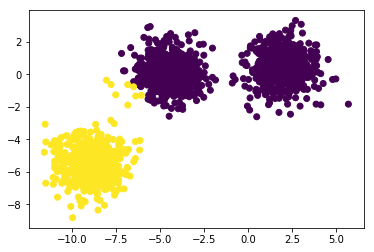

In [68]:
plt.scatter(X[:,0],X[:,1], c=y_pred)

In [74]:
model3 = KMeans(n_clusters=3, random_state=0)
model3.fit(X)
ypred3 = model3.predict(X)

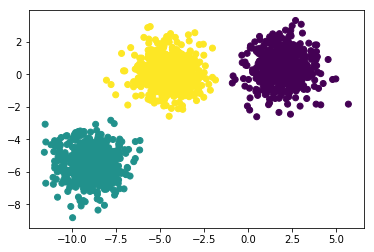

In [78]:
plt.scatter(X[:,0], X[:,1], c = ypred3)

In [82]:
target3 = np.array([[x,y] for y in range(-10, 10) for x in range(-20,10)],)
print target3.shape
score3 = model3.predict(target3)

(600, 2)

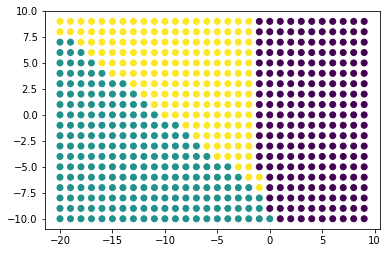

In [85]:
plt.scatter(target3[:,0],target3[:,1], c=score3)

#### Easy Task: segment two frames (a good-Track vs. badTrack) True-Area

In [ ]:
'''
Todos
[x] 3d classifier

Thoughts
 - this is unsupervised and thus can't really truly describe the True/False
   distinction we're trying to capture
 - so we're looking for supervised, but with a cost function that reflects
   regional groupings, yes?
'''

In [180]:
# build data

X = np.empty(shape=(0,3), dtype='uint8')
Y = np.empty(shape=(0,), dtype='uint8')

classifier_counter = 0

for i in (0,3):
    
    _gs = listGSg[i]

    pcm = PixelConfusionMatrix(img = _gs.getOrigFrame()
                              ,threshes = [thresh1]
                              ,circle = _gs.displayInputScore['0']['data']
                              )
    pcm.calc()

    pix1 = pcm.tpPix.copy()
    pix2 = pcm.fnPix.copy()
    
    X = np.concatenate((X,pix1, pix2))
    
    Y = np.concatenate((Y, 
               np.array( [classifier_counter 
                          for _ in range(len(pix1) + len(pix2))
                         ]
                       ,dtype='uint8')
                      ))
    
    classifier_counter += 1
               
print np.unique(Y)
X.shape, Y.shape

[0 1]


((10250, 3), (10250,))

In [181]:
# create model

model = KMeans(n_clusters = 2)
model.fit(X)
y = model.predict(X)

In [182]:
y.shape, X.shape, Y.shape

((10250,), (10250, 3), (10250,))

In [183]:
from modules.AnalysisHelpers import colorCube, bytesToPic2

##### Demonstrate why KMeans fails as a classifier for our purposes

Here we have two "clusters" - that True-Pixels (pix inside ball) from two different frames in the same video. See the "Actual" segmentation figures in column1.


But we're unable to to cluster these oblong bean shapes instead we separate by distance from center of combined mass. See the "Predicted" segmentation in column2.

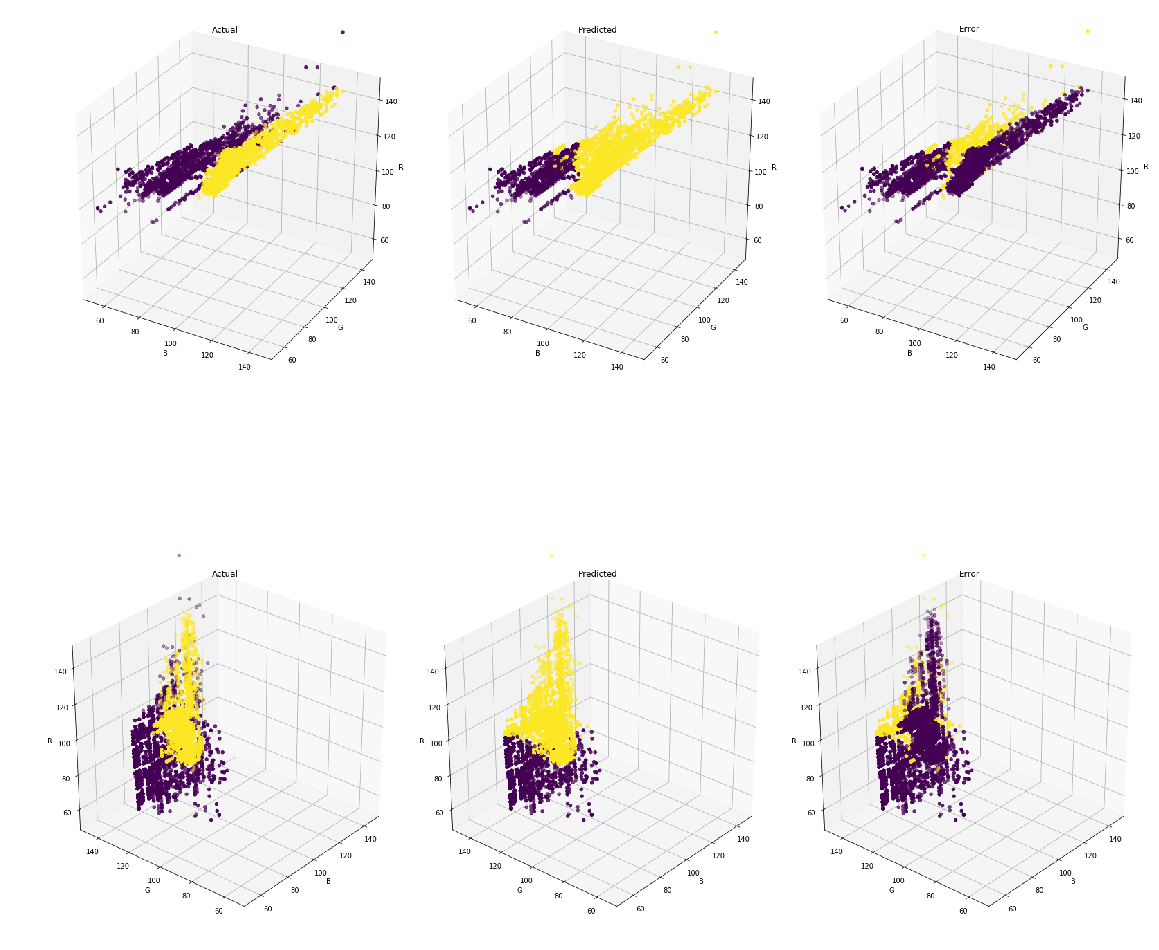

In [197]:
### domain = (0,255)
domain = (50,150)
spaceDefined = {'x':domain, 'y':domain, 'z':domain}
viewPositionDefined =  {'elevation': 30 , 'azimuth':-140}

def buildCharts(bInitPosition = False, viewPositionDefined = {}):
    
    ret = []
    
    ret.append( colorCube(X[:,0], X[:,1], X[:,2]
                    ,listColors = Y
                    ,spaceDefined = spaceDefined
                    ,viewPositionDefined = viewPositionDefined
                    ,bInitPosition = bInitPosition
                    ,figsize= (10,10)
                    ,title = 'Actual'
                    ,bLegend2 = True
                    ,b_save = True))

    ret.append( colorCube(X[:,0], X[:,1], X[:,2]
                    ,listColors = y
                    ,spaceDefined = spaceDefined
                    ,viewPositionDefined = viewPositionDefined
                    ,bInitPosition = bInitPosition
                    ,figsize= (10,10)
                    ,title = 'Predicted'
                    ,bLegend2 = True
                    ,b_save = True))

    err = [0 if y[_i] == Y[_i] else 1 for _i in range(len(y))]

    ret.append( colorCube(X[:,0], X[:,1], X[:,2]
                    ,listColors = err
                    ,spaceDefined = spaceDefined
                    ,viewPositionDefined = viewPositionDefined
                    ,bInitPosition = bInitPosition
                    ,figsize= (10,10)
                    ,title = 'Error'
                    ,bLegend2 = True
                    ,b_save = True))
    
    return ret

# default view

ret = buildCharts()
ret2 = buildCharts(bInitPosition=True, viewPositionDefined = viewPositionDefined)

charts = [
            [ bytesToPic2(ret[0]), bytesToPic2(ret2[0])], 
            [ bytesToPic2(ret[1]), bytesToPic2(ret2[1])], 
            [ bytesToPic2(ret[2]), bytesToPic2(ret2[2])]
        ]
         
multiPlot(charts, bGrid=False, figsize = (20,20), wspace=0, hspace=0)

In [172]:
subprocColorCube(X[:,0], X[:,1], X[:,2]
                ,listColors = err
                ,spaceDefined = spaceDefined)

### Misc

In [ ]:
ev = EvalTracker()
ev.setBaselineScore(score)
ev.checkTrackSuccess(score1)

evalDict = {}
evalDict['distance'] = ev.distanceFromBaseline(score)
evalDict['success'] = ev.checkTrackSuccess(score)
evalDict['inBaseline'] = ev.checkTrackInsideBaseline(score)
#evalDict['inWindow'] = ev.checkTrackInWindow(score)
iterLog['eval'] = evalDict

In [84]:
[_gs.displayInputScore for _gs in listGSg]

[{u'0': {u'data': [436, 320, 68, 68], u'type': u'circle'},
  u'1': {u'data': [442, 324, 60, 62], u'type': u'circle'}},
 {u'0': {u'data': [152, 240, 92, 96], u'type': u'circle'},
  u'1': {u'data': [150, 248, 90, 82], u'type': u'circle'}},
 {u'0': {u'data': [528, 208, 94, 94], u'type': u'circle'},
  u'1': {u'data': [534, 214, 78, 82], u'type': u'circle'}},
 {u'0': {u'data': [1018, 182, 92, 100], u'type': u'circle'},
  u'1': {u'data': [1020, 194, 86, 78], u'type': u'circle'}},
 {u'0': {u'data': [1122, 194, 110, 104], u'type': u'circle'},
  u'1': {u'data': [1128, 202, 96, 90], u'type': u'circle'}},
 {u'0': {u'data': [742, 358, 80, 78], u'type': u'circle'},
  u'1': {u'data': [752, 364, 68, 68], u'type': u'circle'}},
 {u'0': {u'data': [682, 404, 72, 68], u'type': u'circle'},
  u'1': {u'data': [688, 410, 60, 58], u'type': u'circle'}},
 {u'0': {u'data': [678, 480, 22, 22], u'type': u'circle'},
  u'1': {u'data': [680, 482, 18, 18], u'type': u'circle'}},
 {u'0': {u'data': [600, 458, 14, 14], u't